In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def best_runs(file_paths, epochs):
    dataframes = []
    for i in range(len(file_paths)):
        with open(file_paths[i], 'r') as f:
            lines = f.readlines()

        records = [] 
        for line in lines:
            match = re.search(
                r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)", line
            )
            if match:
                mixing_ratio = float(match.group(1))
                learning_rate = float(match.group(2))
                val_loss = float(match.group(3))
                perplexity = float(match.group(4))
                records.append({
                    "mixing_ratio": mixing_ratio, 
                    "learning_rate": learning_rate,
                    "val_loss": val_loss,
                    "perplexity": perplexity
                })

        df = pd.DataFrame(records)
        df_best = df.loc[df.groupby("mixing_ratio")["val_loss"].idxmin()].reset_index(drop=True)
        df_best["experiment"] = f"{epochs[i]}"
        dataframes.append(df_best)

    return dataframes


In [2]:
def get_best_overall_runs(file_paths, epochs):
    best_rows = []

    for i in range(len(file_paths)):
        with open(file_paths[i], 'r') as f:
            lines = f.readlines()

        records = []
        for line in lines:
            match = re.search(
                r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)", line
            )
            if match:
                mixing_ratio = float(match.group(1))
                learning_rate = float(match.group(2))
                val_loss = float(match.group(3))
                records.append({
                    "mixing_ratio": mixing_ratio,
                    "learning_rate": learning_rate,
                    "val_loss": val_loss,
                    "experiment": epochs[i]
                })

        df = pd.DataFrame(records)
        best_row = df.loc[df["val_loss"].idxmin()]  # only the single best run
        best_rows.append(best_row)

    return pd.DataFrame(best_rows)

In [3]:
def plot_reg_and_repeat(iters_repeat, subsamples, model_params, iters_reg, legend_rep, legend_reg, epochs, hq_data, title_addition=None):
    file_paths = []
    for model in model_params:
        for i in range(len(iters_repeat)):
            file_paths.append(f"./summary_logs/{hq_data}/summary_{iters_repeat[i]}iter_{model}_{subsamples[i]}.txt")
    
    #file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
    # file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
    #wiki_#tokens = [2, 4, 8, 16, "(New) 16"]
    # epochs = [2,4,8,16,32]
    dfs = best_runs(file_paths, epochs)
    
    # Display each DataFrame
    '''for df in dfs:
        print(f"Dataframe for 1/{int(32 / int(df['experiment'].iloc[0]))}x {hq_data} (Repeat-Aware)")
        display(df.drop(columns=["experiment"]))'''
    
    plt.figure(figsize=(10, 6))
    legend_idx = 0
    for df in dfs:
        label = df["experiment"].iloc[0]
        # plot_label = f"{label}x Wikipedia"
        plot_label = f"{legend_rep[legend_idx]}"
        legend_idx += 1
    
        # inverse logits space 
        
        #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
        #logit_ratios = np.log(ratios / (1 - ratios))
        #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
        
        #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)
    
        # normal space
        plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)
    # 
    # plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)
    #legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
    #iter_values_reg = [7134, 14268, 28536, 57071, 114142]
    file_paths_reg = []
    #model_params = ["124M"]
    legend_idx = 0
    for model in model_params:
        for val in iter_values_reg:
            file_paths_reg.append(f"./summary_logs/{hq_data}/summary_{val}iter_{model}_1.txt")
            
    dfs_reg = best_runs(file_paths_reg, epochs)  
    for df in dfs_reg:
        label = df["experiment"].iloc[0]
        # plot_label = f"{label}x Wikipedia"
        plot_label = f"{legend_labels_reg[legend_idx]}"
        legend_idx += 1
    
        # inverse logits space 
        
        #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
        #logit_ratios = np.log(ratios / (1 - ratios))
        #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
        
        #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)
    
        # normal space
        plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)

    # Display each DataFrame
    '''for df in dfs_reg:
        print(f"Dataframe for {df['experiment'].iloc[0]}x {hq_data}")
        display(df.drop(columns=["experiment"]))'''
    
    plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
    plt.ylabel("Validation Loss")
    if hq_data == "pubmed":
        plt.title(f"Validation Loss per Mixing Ratio Across Training Horizons for PubMed, {model_params[0]} Model")
    else:
        plt.title(f"Validation Loss per Mixing Ratio Across Training Horizons for Wikipedia, {model_params[0]} Model")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
   
    return file_paths, file_paths_reg, dfs, dfs_reg
    

no asymptote, should be repeating more the more you train. counterpoint to the meunigghoff paper
web crawl regularizing effect, as long as you have enough web crawl to make the mixture fit. as long as you have the web crawl, the optimal epochs is still increasing, decreasing ratio. 
set up is scientifically rigorous enough that can state this. Can say in future work to verify this with larger models/scales. 4-epoch has been recommended to limit at 4, but we dont see this fully. AI2 is a bit more sophisticated, but not too much more. Should do the non-log graphs as well 
Do more experiments to verify what your optimal data mixture should be without just relying on the heuristic 

Seeing what patterns come up, plot it in different ways 

optimal loss on y axis - get diminishing returns
optimal data composition, want the mixture to be optimal

In [ ]:
# 3-Source Experiments. ratios go FineWeb : Wikipedia : PubMed
1/16: mixing_ratio=[0.7, 0.15, 0.15], val_loss_wiki =3.7764, val_loss_pubmed =3.2695, learning_rate=0.00141
1/8: mixing_ratio=[0.7, 0.15, 0.15], val_loss_wiki =3.5665, val_loss_pubmed =3.0782, learning_rate=0.00141
1/4: mixing_ratio=[0.6, 0.2, 0.2], val_loss_wiki =3.4131, val_loss_pubmed =2.9374, learning_rate=0.00141
1/2: mixing_ratio=[0.5, 0.25, 0.25], val_loss_wiki =3.2656,  val_loss_pubmed =2.8084, learning_rate=0.001 
Target: mixing_ratio=[0.3, 0.35, 0.35], val_loss_wiki =3.1732, val_loss_pubmed =2.7122, learning_rate=0.001
# could grid search the 1/16 
# 
# tune one of the base lines, does that perform well at the longer training horizon. Tune 1/16
# automatic tuning w/ bayesian optimziation
# show that the repeat aware / subsampling 
# could put them together / keep them separate for repeat-aware 
# calculate what the differnece is combining/separate
# need single score, averaging would be fine(?) 

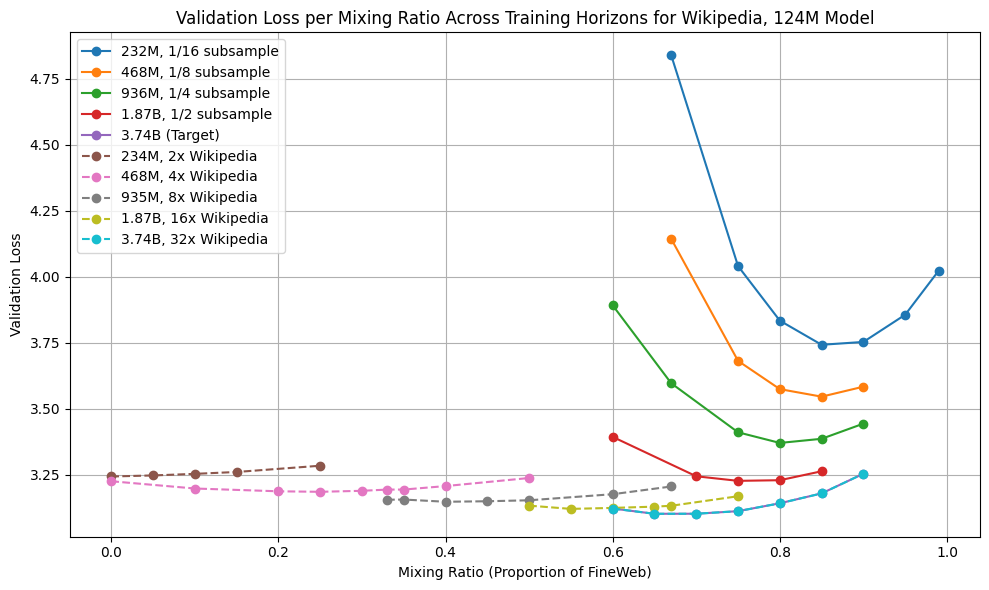

In [4]:
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["124M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_124M, wiki_file_paths_reg_124M, dfs_repeat_wiki_124M, dfs_reg_wiki_124M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

In [3]:
# Calculation for 3-source experiments
# 1/16 Subsample: 7110 iterations for Wikipedia, 0.85 FineWeb 0.15 Wikipedia 
# 7366 iterations for PubMed, 0.85 FineWeb 0.15 PubMed 
# -> 3-source experiments, 0.7 0.15 0.15 for 7238 iterations
# Since we're operating with the same horizons as before. Take a (weighted) average of the number of iterations for the experiments
(7366 + 7110) / 2
# Validation on both of the data sources, take half of each?

7238.0

In [5]:
# Actual Loss / Optimal Loss From Subsample Mixture Ratios 
for df in dfs_reg_wiki_124M:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

data = {
    'Subsample Used': ["1/16", "1/8", "1/4", "1/2"],
    'Loss / Optimal Loss on Target Horizon': [3.18/3.0998, 3.18/3.0998, 3.1425/3.0998, 3.1127/3.0998]
}
df = pd.DataFrame(data)
print(df)

Dataframe for 2x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00200,3.2440,25.6353
1,0.05,0.00141,3.2480,25.7389
2,0.10,0.00141,3.2540,25.8930
3,0.15,0.00200,3.2611,26.0791
4,0.25,0.00141,3.2848,26.7034


Dataframe for 4x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00141,3.2260,25.1783
1,0.10,0.00141,3.1985,24.4963
2,0.20,0.00141,3.1879,24.2386
3,0.25,0.00200,3.1860,24.1919
4,0.30,0.00141,3.1898,24.2839
5,0.33,0.00141,3.1944,24.3956
6,0.35,0.00141,3.1945,24.3989
7,0.40,0.00141,3.2077,24.7222
8,0.50,0.00141,3.2383,25.4892


Dataframe for 8x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.33,0.00141,3.1560,23.4775
1,0.35,0.00100,3.1567,23.4922
2,0.40,0.00141,3.1483,23.2967
3,0.45,0.00141,3.1502,23.3401
4,0.50,0.00141,3.1539,23.4262
5,0.60,0.00141,3.1769,23.9722
6,0.67,0.00141,3.2061,24.6826


Dataframe for 16x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,3.1336,22.9574
1,0.55,0.001,3.1213,22.6757
2,0.60,0.001,3.1250,22.7601
3,0.65,0.001,3.1298,22.8691
4,0.67,0.001,3.1331,22.9452
5,0.75,0.001,3.1692,23.7883


Dataframe for 32x Wikipedia


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.001,3.1227,22.7067
1,0.65,0.001,3.1027,22.2570
2,0.67,0.001,3.0998,22.1940
3,0.70,0.001,3.1029,22.2627
4,0.75,0.001,3.1127,22.4818
5,0.80,0.001,3.1425,23.1621
6,0.85,0.001,3.1800,24.0465
7,0.90,0.001,3.2545,25.9059


  Subsample Used  Loss / Optimal Loss on Target Horizon
0           1/16                               1.025873
1            1/8                               1.025873
2            1/4                               1.013775
3            1/2                               1.004162


In [16]:
# Logistic Regression, multiply the mixing ratio by the number of wikipedia tokens to get the epochs of Wikipedia 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

def mix_and_epochs(file_paths_lists, epochs, num_tokens, params=["30M", "124M", "345M"], colors=["blue", "red", "orange"], title = None):
    plt.figure(figsize=(8, 5))
    colors = colors
    params = params
    coefs = []
    intercepts = []
    
    for idx, file_paths in enumerate(file_paths_lists):
        df_best = get_best_overall_runs(file_paths, epochs)
        df_best["experiment"] = df_best["experiment"].astype(float)
        
        df_best["optimal_epochs"] = df_best["experiment"] * (1 - df_best["mixing_ratio"])
        
        df_best["tokens"] = (df_best["experiment"] * num_tokens)
        # df_best["log_wiki_epochs"] = np.log(df_best["wiki_epochs"])
        
        # X = wiki_epochs, y = optimal mixing_ratio
        X = (np.log(df_best[["tokens"]].values))
        y = (np.log(df_best["optimal_epochs"].values))
        
        reg = LinearRegression()
        reg.fit(X, y)
        print(reg.coef_)
        print(reg.intercept_)
        coefs.append(reg.coef_[0])
        intercepts.append(reg.intercept_)
        
        x_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
        y_pred = reg.predict(x_test)
        
        
        plt.scatter(X, y, color = colors[idx], label=f"Best Mixing Ratio per Experiment ({params[idx]})")
        plt.plot(x_test, y_pred, color = colors[idx], label=f"Line of Best Fit ({params[idx]})")

    
    '''df_best_2 = get_best_overall_runs(file_paths_2, epochs)
    df_best_2["experiment"] = df_best_2["experiment"].astype(float)
    
    df_best_2["optimal_epochs"] = df_best_2["experiment"] * (1 - df_best_2["mixing_ratio"])
    
    df_best_2["tokens"] = (df_best_2["experiment"] * num_tokens)
    # df_best["log_wiki_epochs"] = np.log(df_best["wiki_epochs"])
    
    # X = wiki_epochs, y = optimal mixing_ratio
    X_2 = (np.log(df_best_2[["tokens"]].values))
    y_2 = (np.log(df_best_2["optimal_epochs"].values))
    
    reg_2 = LinearRegression()
    reg_2.fit(X_2, y_2)
    print(reg_2.coef_)
    print(reg_2.intercept_)
    
    x_test_2 = np.linspace(X_2.min(), X_2.max(), 100).reshape(-1, 1)
    y_pred_2 = reg.predict(x_test_2)
    
   # plt.figure(figsize=(8, 5))
    plt.scatter(X_2, y_2, color="blue", label="Best Mixing Ratio per Experiment")
    plt.plot(x_test_2, y_pred_2, color="blue", label="Line of Best Fit")'''
    
    plt.xlabel("ln(Total Training Tokens)")
    plt.ylabel("ln(Optimal Epochs)")
    if title:
        plt.title(title)
    else:
        plt.title("Optimal Epochs over Training Horizons")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return coefs, intercepts
    # wikipedia usually considered ~ highest quality 
    # do repeat scaling laws for lower quality domains
    # fineweb edu

In [ ]:
# inverse logits space for x axis
# .25 .33 .5 .75 0.9
# could add standard dev as error bars on the graph 
# how to fit predictions, logistic regression on the optimal mixing ratio as y target and raw number of epochs, log number of epochs
# 1, 2, 4, 8, 16 Wikipedia 
# Scale invariance is good reason to do the log number of epochs ?

# this is how you should set your weights, see if experiments tell us a cap on high quality vs low quality 

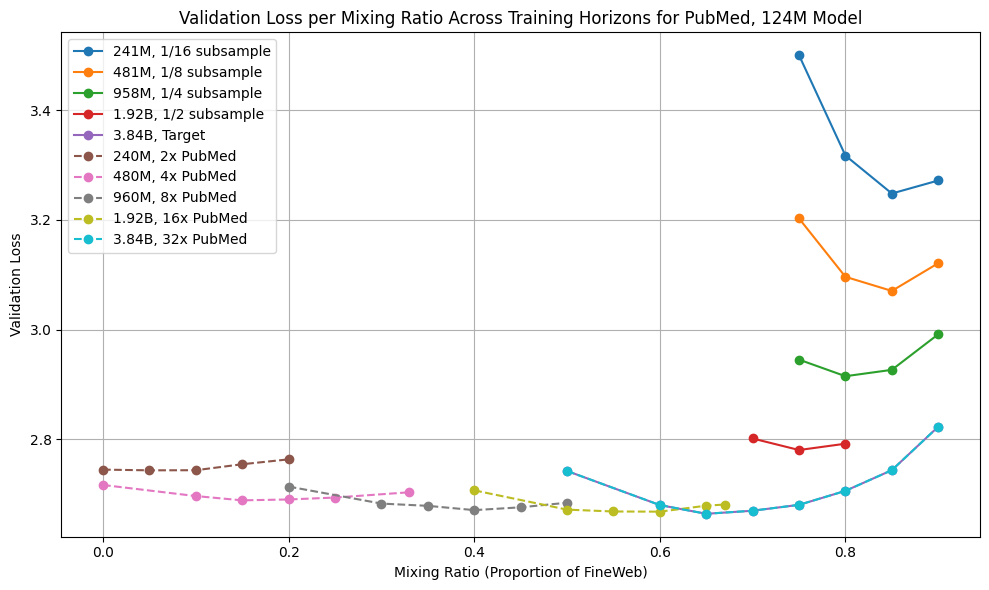

In [7]:
# Do the new method for pubmed here, and also get the loss / optimal loss for it 
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["124M"]
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_124M, pubmed_file_paths_reg_124M, dfs_repeat_pubmed_124M, dfs_reg_pubmed_124M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

In [8]:
# Actual Loss / Optimal Loss From Subsample Mixture Ratios 
for df in dfs_reg_pubmed_124M:
    print(f"Dataframe for {df['experiment'].iloc[0]}x PubMed")
    display(df.drop(columns=["experiment"]))

data = {
    'Subsample Used': ["1/16", "1/8", "1/4", "1/2"],
    'Loss / Optimal Loss on Target Horizon': [2.7440/2.6670, 2.7440	/2.6670, 2.7063/2.6670, 2.6808/2.6670]
}
df = pd.DataFrame(data)
print(df)

Dataframe for 2x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.002,2.7450,15.5640
1,0.05,0.002,2.7437,15.5442
2,0.10,0.002,2.7439,15.5470
3,0.15,0.002,2.7548,15.7179
4,0.20,0.002,2.7637,15.8585


Dataframe for 4x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.00,0.00282,2.7170,15.1348
1,0.10,0.00200,2.6968,14.8327
2,0.15,0.00200,2.6890,14.7170
3,0.20,0.00200,2.6906,14.7407
4,0.25,0.00141,2.6941,14.7929
5,0.33,0.00200,2.7037,14.9342


Dataframe for 8x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.20,0.00200,2.7141,15.0904
1,0.30,0.00141,2.6831,14.6303
2,0.35,0.00141,2.6790,14.5712
3,0.40,0.00141,2.6712,14.4572
4,0.45,0.00141,2.6763,14.5308
5,0.50,0.00141,2.6847,14.6539


Dataframe for 16x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.40,0.00141,2.7072,14.9880
1,0.50,0.00141,2.6721,14.4709
2,0.55,0.00100,2.6687,14.4214
3,0.60,0.00100,2.6684,14.4162
4,0.65,0.00100,2.6793,14.5748
5,0.67,0.00100,2.6814,14.6062


Dataframe for 32x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,2.7425,15.5258
1,0.60,0.001,2.6804,14.5914
2,0.65,0.001,2.6645,14.3602
3,0.70,0.001,2.6701,14.4409
4,0.75,0.001,2.6808,14.5973
5,0.80,0.001,2.7063,14.9736
6,0.85,0.001,2.7440,15.5493
7,0.90,0.001,2.8232,16.8306


  Subsample Used  Loss / Optimal Loss on Target Horizon
0           1/16                               1.028871
1            1/8                               1.028871
2            1/4                               1.014736
3            1/2                               1.005174


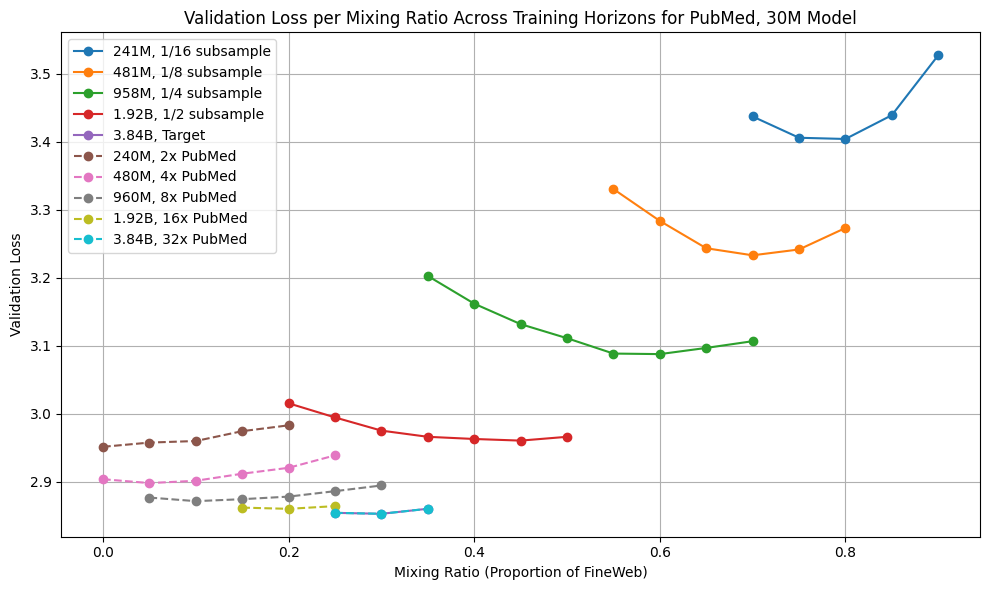

In [9]:
# Different Model Size: 30M Parameters, PubMed
# Do the new method for pubmed here, and also get the loss / optimal loss for it 
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["30M"]
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_30M, pubmed_file_paths_reg_30M, dfs_repeat_pubmed_30M, dfs_reg_pubmed_30M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

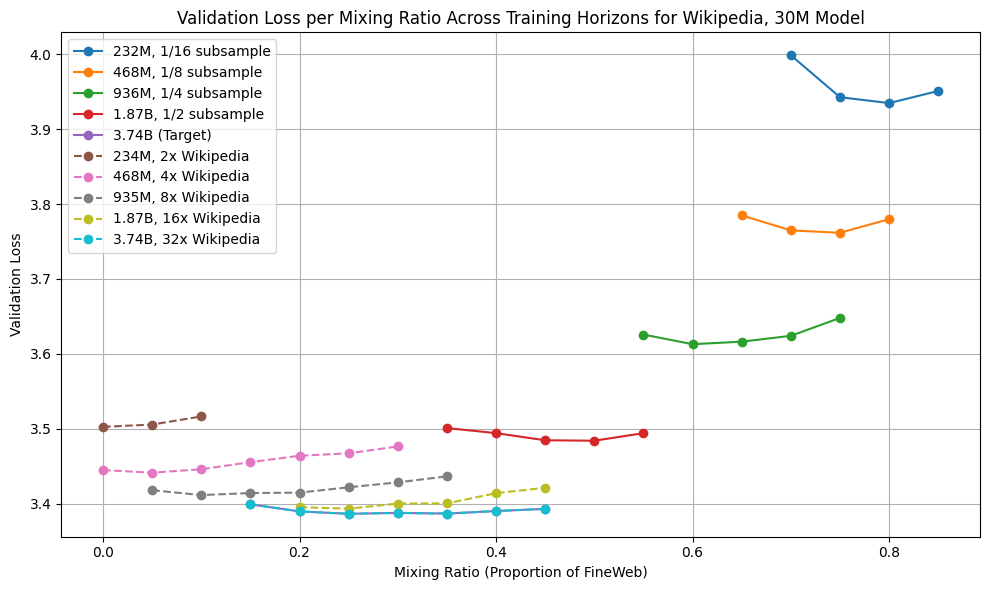

In [10]:
# Do the full graphs for small model wikipedia 
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["30M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_30M, wiki_file_paths_reg_30M, dfs_repeat_wiki_30M, dfs_reg_wiki_30M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

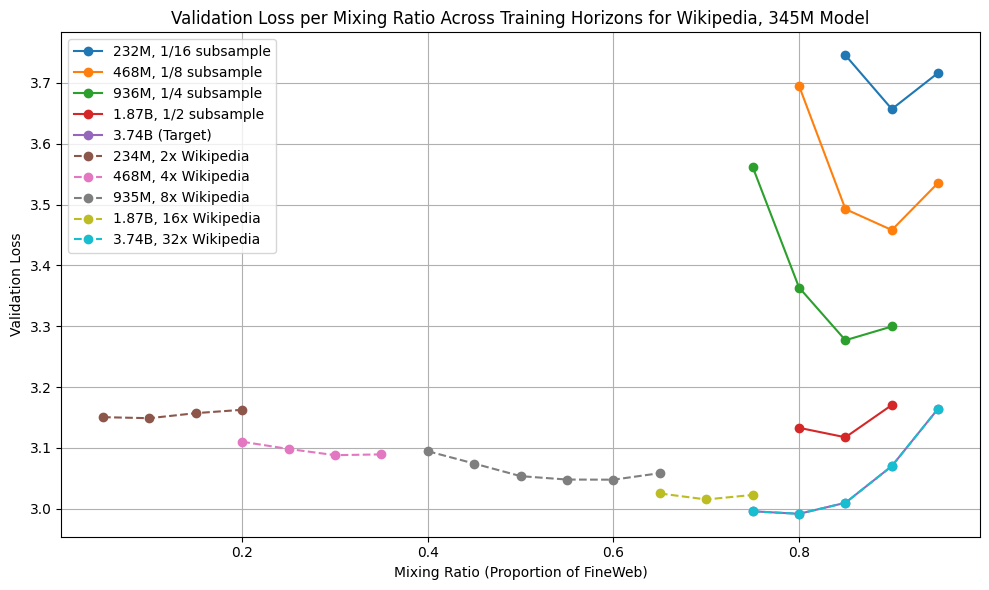

In [13]:
iter_repeat = [7110, 14280, 28566, 57118, 114142] 
subsamples = [16, 8, 4, 2, 1]
model_params = ["345M"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
epochs = [2,4,8,16,32]
hq_data = "wikipedia"
wiki_file_paths_345M, wiki_file_paths_reg_345M, dfs_repeat_wiki_345M, dfs_reg_wiki_345M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

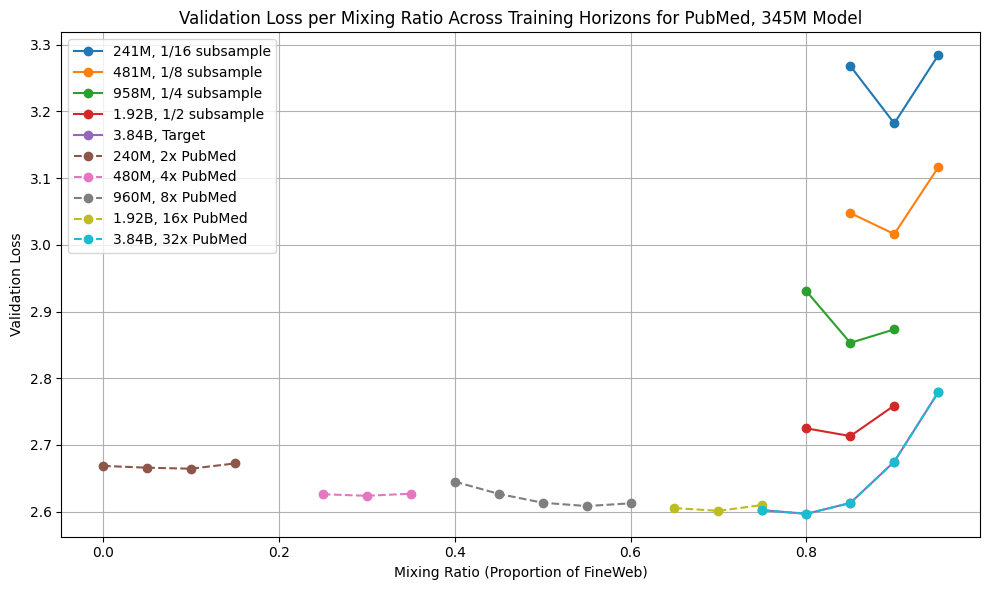

In [14]:
# Different Model Size: 30M Parameters, PubMed
# Do the new method for pubmed here, and also get the loss / optimal loss for it 
#iter_repeat = [7366, 14679]
iter_repeat = [7366, 14679, 29249, 58566, 117188]
subsamples = [16, 8, 4, 2, 1]
model_params = ["345M"]
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
# iter_values_reg = [7324, 14649, 29297, 58594, 117188]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
epochs = [2,4,8,16,32]
hq_data = "pubmed"
pubmed_file_paths_345M, pubmed_file_paths_reg_345M, dfs_repeat_pubmed_345M, dfs_reg_pubmed_345M = plot_reg_and_repeat(iter_repeat, subsamples, model_params, iter_values_reg, legend_labels, legend_labels_reg, epochs, hq_data)

[0.60641103]
-10.987786529045447


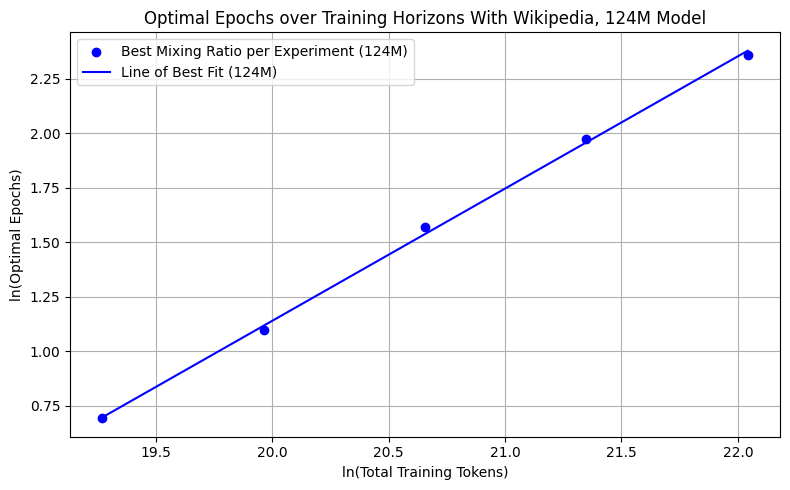

In [49]:
# Graph the Epochs for Wikipedia 124M
paths = [wiki_file_paths_reg_124M]
coefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, params=["124M"], title="Optimal Epochs over Training Horizons With Wikipedia, 124M Model")

[0.88288881]
-16.30400980836542
[0.60641103]
-10.987786529045447


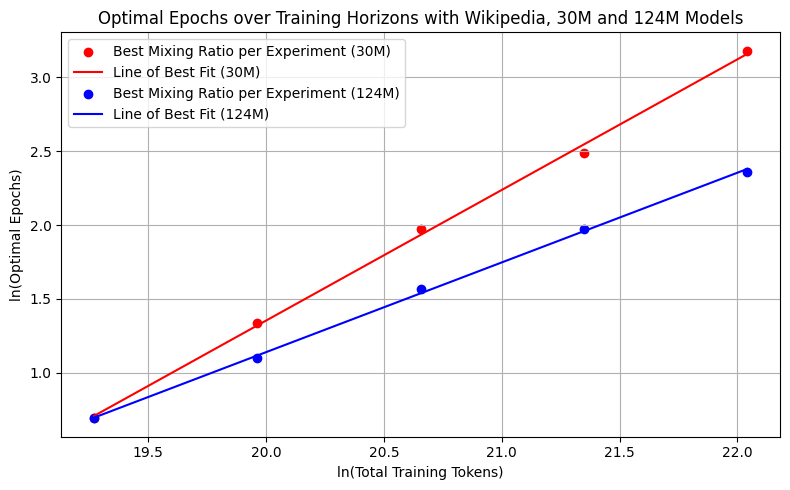

In [55]:
# Graph the Epochs for Wikipedia 30M
paths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M]
coefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, params=["30M", "124M"], colors=["red", "blue"], title="Optimal Epochs over Training Horizons with Wikipedia, 30M and 124M Models")

[0.44377576]
-7.9255864101796405


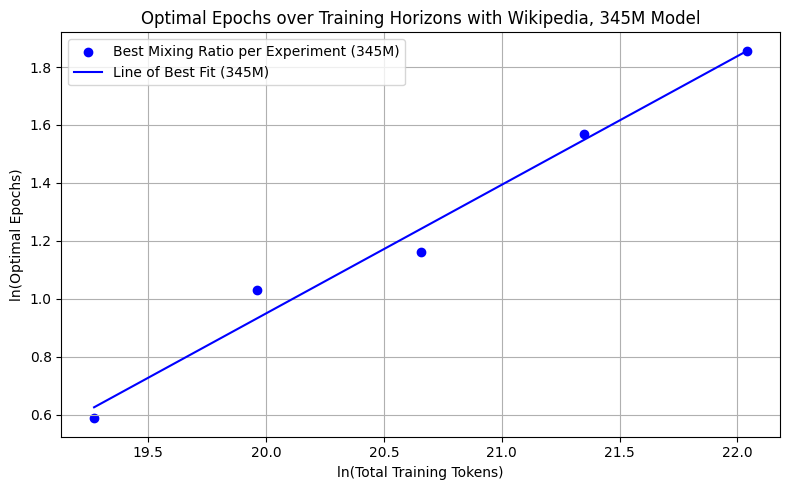

In [51]:
# Graph the Epochs for Wikipedia 345M
paths = [wiki_file_paths_reg_345M]
coefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, params=["345M"], title="Optimal Epochs over Training Horizons with Wikipedia, 345M Model")

[0.88288881]
-16.30400980836542
[0.60641103]
-10.987786529045447
[0.44377576]
-7.9255864101796405


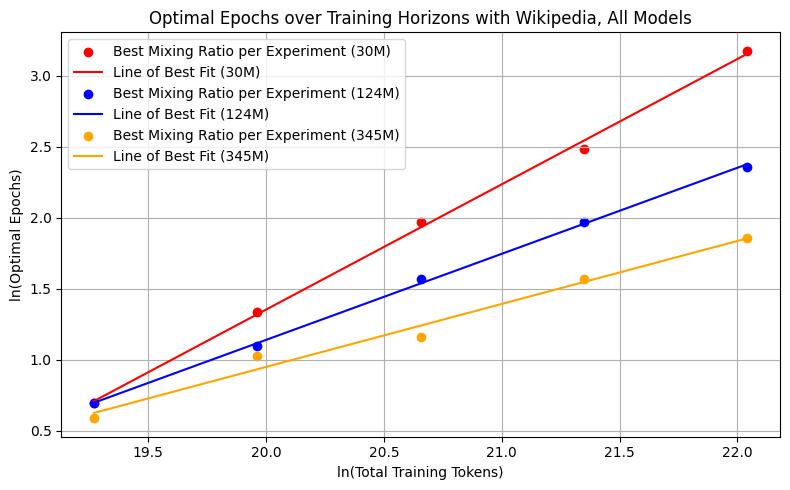

In [19]:
# Graph the Epochs for Wikipedia
paths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M, wiki_file_paths_reg_345M]
coefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with Wikipedia, All Models")

In [15]:
print(coefs_wiki_all) # Wikipedia

[np.float64(0.8828888083607248), np.float64(0.5894185263558942), np.float64(0.4437757575778928)]


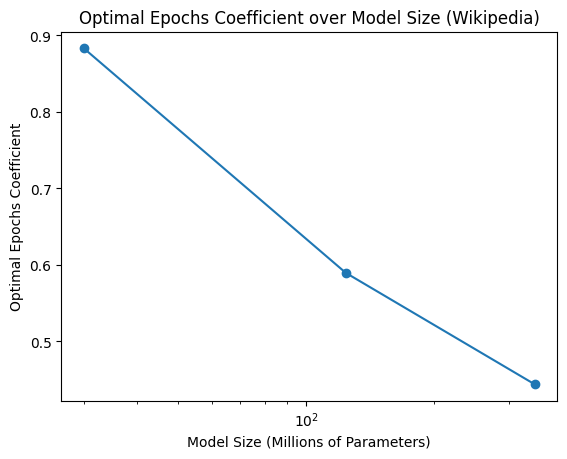

In [16]:
x = (([30, 124, 345]))
y = coefs_wiki_all

plt.plot(x, y, '-o') 

plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Optimal Epochs Coefficient")
plt.title("Optimal Epochs Coefficient over Model Size (Wikipedia)")
plt.xscale("log")
plt.show()

[0.87229261]
-16.108996360599146
[0.6031392]
-10.933101484176362
[0.44377576]
-7.913716639457752


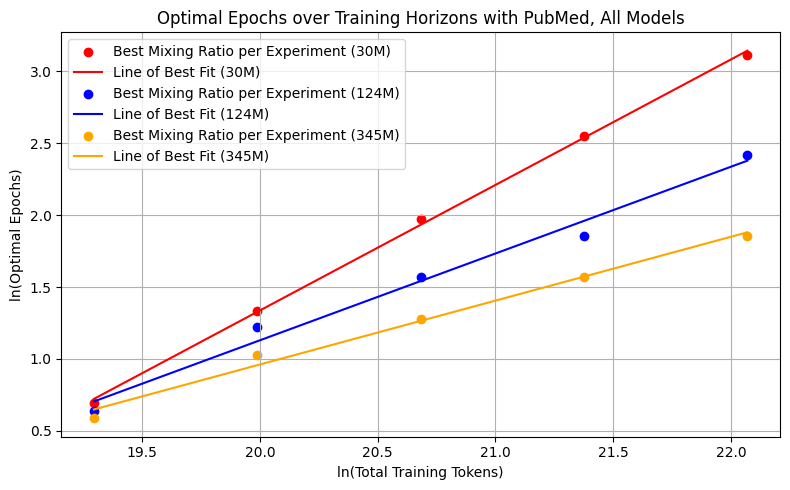

'\n# Graph the Epochs for Wikipedia\npaths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M, wiki_file_paths_reg_345M]\ncoefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with Wikipedia, All Models")\n'

In [20]:
paths = [pubmed_file_paths_reg_30M, pubmed_file_paths_reg_124M, pubmed_file_paths_reg_345M]
coefs_pubmed_all, intercepts_pubmed_all = mix_and_epochs(paths, epochs, 120000060, colors=["red", "blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with PubMed, All Models")
'''
# Graph the Epochs for Wikipedia
paths = [wiki_file_paths_reg_30M, wiki_file_paths_reg_124M, wiki_file_paths_reg_345M]
coefs_wiki_all, intercepts_wiki_all = mix_and_epochs(paths, epochs, 116881107, colors=["red","blue", "orange"], params=["30M", "124M", "345M"], title="Optimal Epochs over Training Horizons with Wikipedia, All Models")
'''

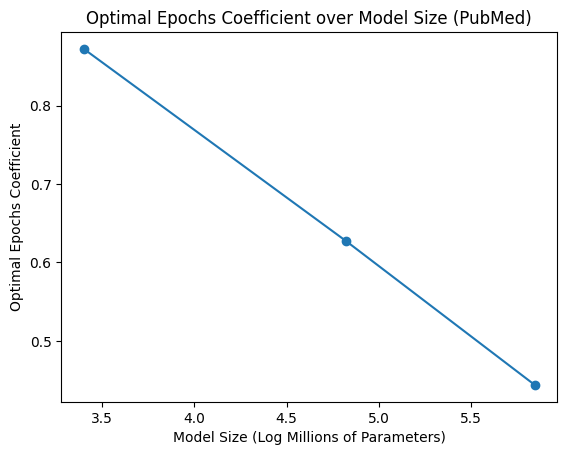

In [20]:
x = np.log(([30, 124, 345]))
y = coefs_pubmed_all

plt.plot(x, y, '-o') 

plt.xlabel("Model Size (Log Millions of Parameters)")
plt.ylabel("Optimal Epochs Coefficient")
plt.title("Optimal Epochs Coefficient over Model Size (PubMed)")
plt.show()

In [23]:
# Plotting the optimal learning rates for each set of experiments
def get_optimal_learning_rates_nested(df_groups, model_sizes, training_horizons):
    """
    Args:
        df_groups: list of lists of DataFrames (some entries may be None or missing)
        model_sizes: list of strings (same length as df_groups)
        training_horizons: list of floats (same length as each sublist in df_groups)

    Returns:
        Dict mapping model_size -> list of (training_horizon, optimal_learning_rate)
    """
    from collections import defaultdict

    results = defaultdict(list)

    assert len(df_groups) == len(model_sizes), "Mismatch between model_sizes and df_groups"

    for model_size, df_list in zip(model_sizes, df_groups):
        for df, horizon in zip(df_list, training_horizons):
            if df is None or df.empty:
                continue  # skip if no data for this horizon

            if 'val_loss' not in df.columns or df['val_loss'].isnull().all():
                continue  # skip if no valid val_loss

            best_row = df.loc[df['val_loss'].idxmin()]
            results[model_size].append((horizon, best_row['learning_rate']))

        # Sort by horizon just in case
        results[model_size].sort(key=lambda x: x[0])

    return results


def plot_optimal_learning_rates(results, experiment_type = "Regular"):
    """
    Given a dict {model_size: list of (horizon, lr)}, plot the results.
    """
    plt.figure(figsize=(8,6))

    for model_size, horizon_lrs in results.items():
        horizons, lrs = zip(*horizon_lrs)
        plt.plot(horizons, lrs, marker='o', label=f'{model_size} model')

    plt.xlabel("Training Horizon (tokens)")
    plt.ylabel("Optimal Learning Rate")
    plt.title(f"Optimal Learning Rate vs Training Horizon ({experiment_type})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Try to get code that plots learning rate against validation loss or relates them somehow 

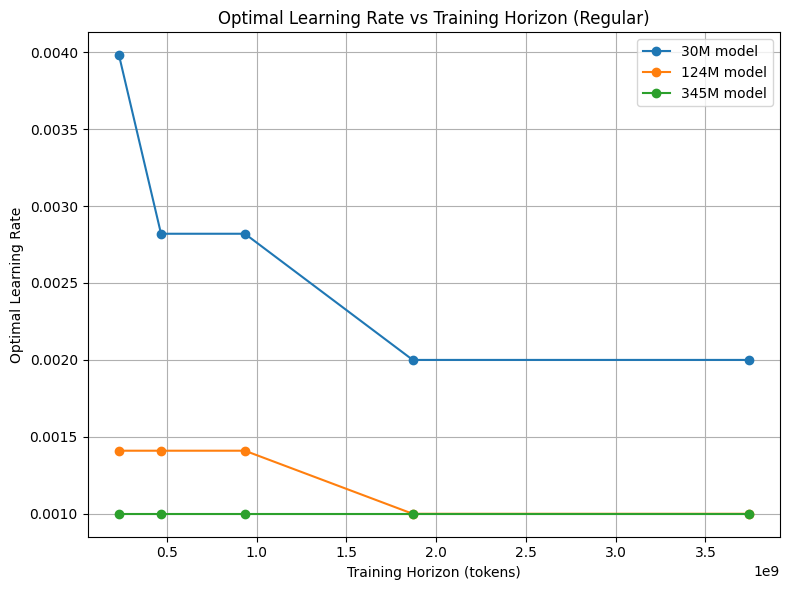

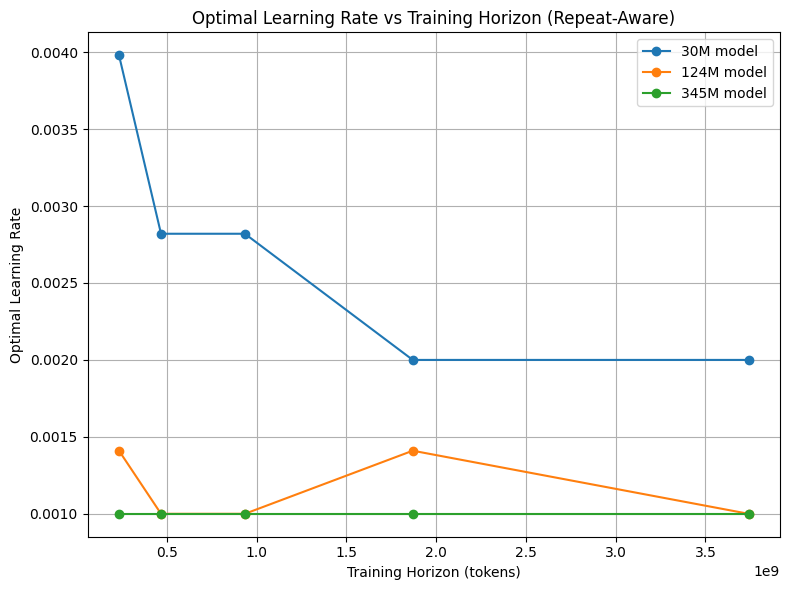

In [24]:
# dfs_repeat_wiki_30M, dfs_reg_wiki_30M
list_dfs_wiki = [dfs_reg_wiki_30M, dfs_reg_wiki_124M, dfs_reg_wiki_345M]
list_dfs_wiki_repeat = [dfs_repeat_wiki_30M, dfs_repeat_wiki_124M, dfs_repeat_wiki_345M]
model_sizes_wiki = ["30M", "124M", "345M"]
# ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
training_horizons_wiki = [234e6, 468e6, 935e6, 187e7, 374e7]
# ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
training_horizons_wiki_repeat = [232e6, 468e6, 936e6, 187e7, 374e7]
results_wiki_reg = get_optimal_learning_rates_nested(list_dfs_wiki, model_sizes_wiki, training_horizons_wiki)
plot_optimal_learning_rates(results_wiki_reg)
results_wiki_repeat = get_optimal_learning_rates_nested(list_dfs_wiki_repeat, model_sizes_wiki, training_horizons_wiki) 
# note that the .00141 "outlier" was only better by .0001
plot_optimal_learning_rates(results_wiki_repeat, "Repeat-Aware")

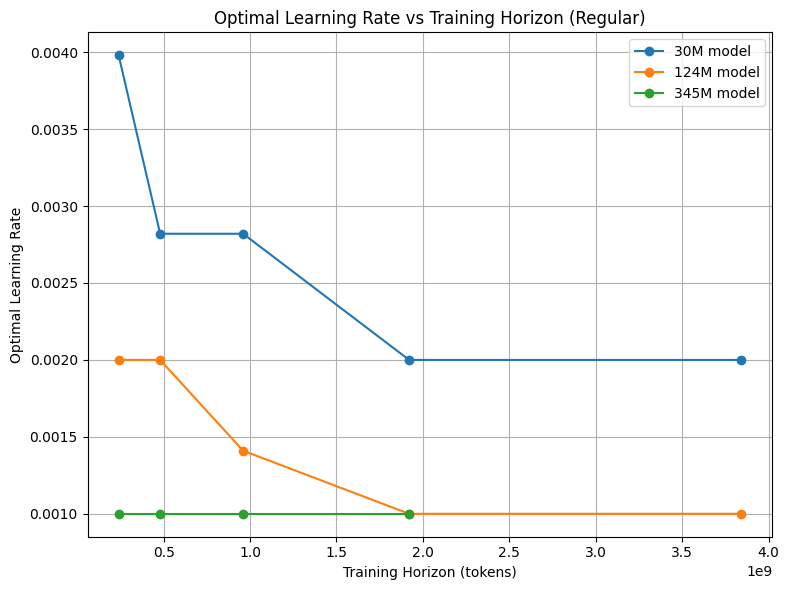

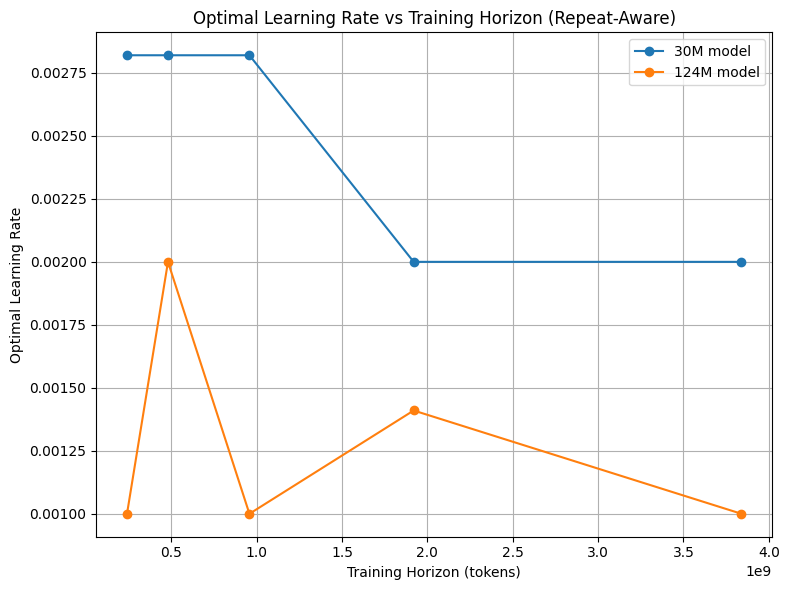

In [28]:
list_dfs_pub = [dfs_reg_pubmed_30M, dfs_reg_pubmed_124M, dfs_reg_pubmed_345M]
model_sizes_pub = ["30M", "124M", "345M"]
# ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"
training_horizons_pub = [240e6, 480e6, 960e6, 192e7, 384e7]
results_pub = get_optimal_learning_rates_nested(list_dfs_pub, model_sizes_pub, training_horizons_pub)
# legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "958M, 1/4 subsample", "1.92B, 1/2 subsample", "3.84B, Target"]
training_horizons_pub_repeat = [241e6, 481e6, 958e6, 192e7, 384e7]
list_dfs_pub_repeat = [dfs_repeat_pubmed_30M, dfs_repeat_pubmed_124M]
plot_optimal_learning_rates(results_pub)
model_sizes_pub_repeat = ["30M", "124M"]
results_pub_repeat = get_optimal_learning_rates_nested(list_dfs_pub_repeat, model_sizes_pub_repeat, training_horizons_pub_repeat)
plot_optimal_learning_rates(results_pub_repeat, "Repeat-Aware")

In [45]:
import re
import pandas as pd
import matplotlib.pyplot as plt

LOG_RE = re.compile(
    r"mixing_ratio=([\d.]+), learning_rate=([\d.]+), val_loss=([\d.]+), perplexity=([\d.]+)"
)

def all_runs_df(file_paths, epochs):
    rows = []
    for path, exp in zip(file_paths, epochs):
        with open(path, "r") as f:
            for line in f:
                m = LOG_RE.search(line)
                if not m:
                    continue
                rows.append({
                    "experiment": str(exp),
                    "mixing_ratio": float(m.group(1)),
                    "learning_rate": float(m.group(2)),
                    "val_loss": float(m.group(3)),
                    "perplexity": float(m.group(4)),
                })
    return pd.DataFrame(rows)

def plot_loss_vs_lr(df, experiment=None):
    d = df.copy()
    if experiment is not None:
        d = d[d["experiment"] == str(experiment)]

    # sort by lr within each mix so lines don’t zig-zag
    for mix, g in d.groupby("mixing_ratio"):
        g = g.sort_values("learning_rate")
        plt.plot(g["learning_rate"], g["val_loss"], marker="o", label=f"mix={mix:g}")

    plt.xscale("log")  # usually helpful for LR sweeps
    plt.xlabel("learning rate")
    plt.ylabel("validation loss")
    plt.title(f"Val loss vs LR{' — '+str(experiment) if experiment else ''}")
    plt.legend()
    plt.tight_layout()
    plt.show()

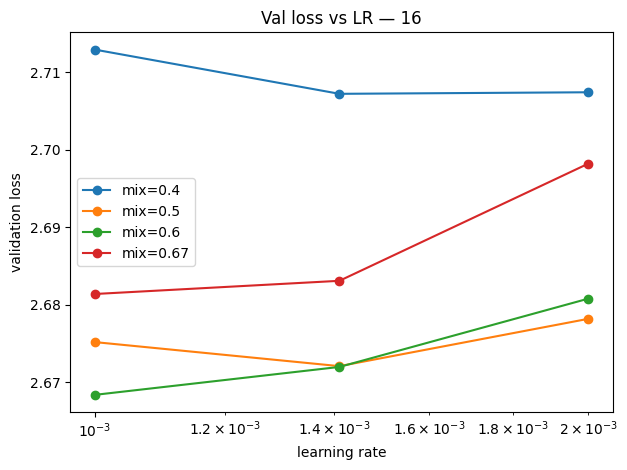

In [47]:
pubmed_124M = all_runs_df(pubmed_file_paths_reg_124M, [2,4,8,16,32])
plot_loss_vs_lr(pubmed_124M, experiment=16)

In [48]:
import math
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.acquisition import AcquisitionFunction

# --- data helpers ---
def prepare_xy(runs):
    X_list, Y_list = [], []
    for r in runs:
        p1, p2, p3 = r["mix"]
        B = r["tokens"]
        y = r["val_loss"]
        X_list.append([p1, p2, math.log10(B)])   # p3 is implied
        Y_list.append([y])
    X = torch.tensor(X_list, dtype=torch.double)
    Y = torch.tensor(Y_list, dtype=torch.double)
    return X, Y

# --- stick-breaking (u,v) -> (p1,p2,p3) ---
def stick_break(UV):
    # UV: (..., 2) in [0,1]
    u1 = UV[..., 0]
    u2 = UV[..., 1]
    p1 = u1
    p2 = (1.0 - u1) * u2
    p3 = 1.0 - p1 - p2
    return torch.stack([p1, p2, p3], dim=-1)  # (..., 3)

# --- acquisition: negative posterior mean at fixed B* ---
class NegativePosteriorMeanAtB(AcquisitionFunction):
    def __init__(self, model, Bstar_log10):
        super().__init__(model)
        # Cache dtype/device from model inputs
        Xtrain = model.train_inputs[0]
        self.Bstar = torch.tensor(Bstar_log10, dtype=Xtrain.dtype, device=Xtrain.device)

    def forward(self, UV):
        """
        UV shape: (batch, q, 2) or (q, 2). Return shape: (batch,)
        We minimize mean loss by maximizing negative mean.
        """
        if UV.dim() == 2:  # (q,2) -> (1,q,2)
            UV = UV.unsqueeze(0)
        # Map to simplex
        P = stick_break(UV)  # (batch, q, 3)
        p1 = P[..., 0]
        p2 = P[..., 1]
        # Build model inputs [p1, p2, log10(B)]
        Bcol = torch.full_like(p1, self.Bstar)
        Xcand = torch.stack([p1, p2, Bcol], dim=-1)  # (batch, q, 3)
        post = self.model.posterior(Xcand)
        mean = post.mean.squeeze(-1)  # (batch, q)
        # For q=1, reduce over q to get (batch,)
        return -mean.squeeze(-1)

def predict_best_mix_botorch(runs, target_tokens=3.2e9):
    X, Y = prepare_xy(runs)

    gp = SingleTaskGP(
        X, Y,
        input_transform=Normalize(d=3),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    Bstar = math.log10(target_tokens)
    acq = NegativePosteriorMeanAtB(gp, Bstar)

    # Optimize over UV in [0,1]^2
    bounds_uv = torch.tensor([[0.0, 0.0], [1.0, 1.0]], dtype=X.dtype, device=X.device)
    cand, _ = optimize_acqf(
        acq_function=acq,
        bounds=bounds_uv,
        q=1,
        num_restarts=10,
        raw_samples=64,
    )

    # Map back to mixture and report predicted mean loss
    p = stick_break(cand.squeeze(0)).detach()  # (3,)
    p1, p2, p3 = p.tolist()
    X_best = torch.tensor([[p1, p2, Bstar]], dtype=X.dtype, device=X.device)
    with torch.no_grad():
        mu = gp.posterior(X_best).mean.item()

    return {"p1": p1, "p2": p2, "p3": p3, "pred_loss": mu}


In [49]:

runs = [
        {"mix": (0.6, 0.3, 0.1), "tokens": 2.0e8, "val_loss": 3.10},
        {"mix": (0.4, 0.4, 0.2), "tokens": 4.0e8, "val_loss": 2.95},
        {"mix": (0.3, 0.6, 0.1), "tokens": 8.0e8, "val_loss": 2.78},
        {"mix": (0.2, 0.4, 0.4), "tokens": 1.6e9, "val_loss": 2.71},
        # ... add your experiments
    ]
out = predict_best_mix_botorch(runs, target_tokens=3.2e9)
print(out)  # {'p1': ..., 'p2': ..., 'p3': ..., 'pred_loss': ...}

{'p1': 0.1848142636041989, 'p2': 0.5320996052019289, 'p3': 0.28308613119387216, 'pred_loss': 2.715206625515696}


In [ ]:
# Code below is for storage / archiving purposes in case I need something later

Dataframe for 2x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00100,3.5000,33.1152
1,0.80,0.00100,3.3172,27.5829
2,0.85,0.00100,3.2481,25.7426
3,0.90,0.00141,3.2718,26.3600


Dataframe for 4x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00141,3.2026,24.5961
1,0.80,0.00100,3.0963,22.1168
2,0.85,0.00200,3.0706,21.5541
3,0.90,0.00141,3.1211,22.6720


Dataframe for 8x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.75,0.00141,2.9454,19.0185
1,0.80,0.00100,2.9152,18.4527
2,0.85,0.00141,2.9268,18.6677
3,0.90,0.00100,2.9916,19.9183


Dataframe for 16x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.60,0.00100,2.9210,18.5607
1,0.70,0.00141,2.8017,16.4721
2,0.75,0.00141,2.7807,16.1304
3,0.80,0.00100,2.7922,16.3168


Dataframe for 32x PubMed


,mixing_ratio,learning_rate,val_loss,perplexity
0,0.50,0.001,2.7425,15.5258
1,0.60,0.001,2.6804,14.5914
2,0.67,0.001,2.6670,14.3961
3,0.75,0.001,2.6808,14.5973


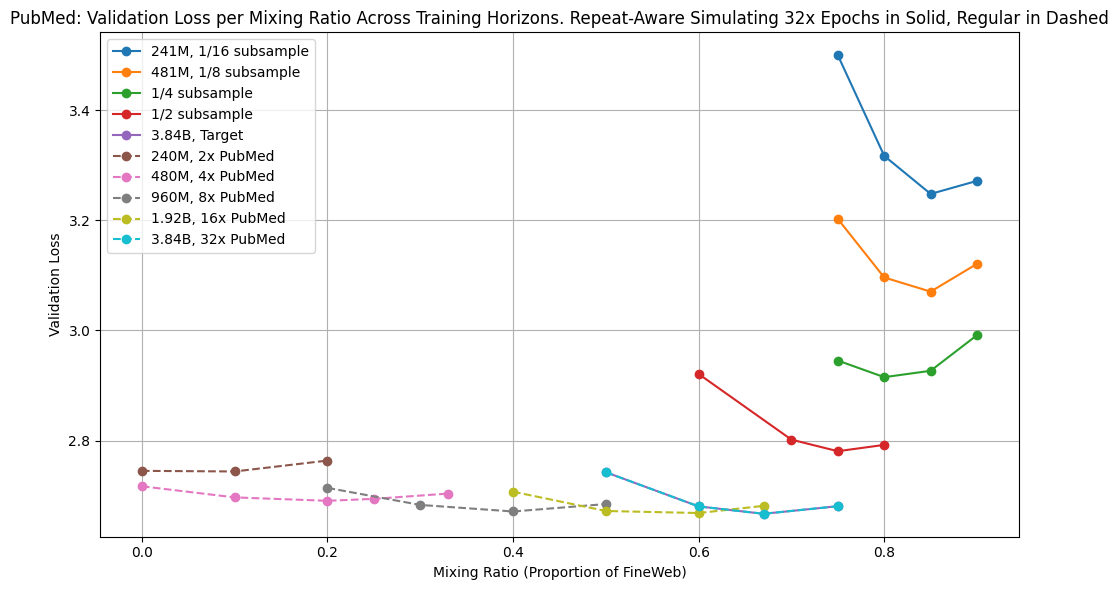

In [9]:
from scipy.special import logit
# repeat aware 
iter_values = [7366, 14679, 29249, 58566, 117188]
file_paths = []
model_params = ["124M"]
subsamples = [16, 8, 4, 2, 1]
for model in model_params:
    for i in range(len(iter_values)):
        file_paths.append(f"./summary_logs/pubmed/summary_{iter_values[i]}iter_{model}_{subsamples[i]}.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
pubmed_tokens = [2,4,8,16,32]
legend_labels = ["241M, 1/16 subsample", "481M, 1/8 subsample", "1/4 subsample", "1/2 subsample", "3.84B, Target"]
dfs = best_runs(file_paths, pubmed_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x PubMed")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


# 
# plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)
legend_labels_reg = ["240M, 2x PubMed", "480M, 4x PubMed", "960M, 8x PubMed", "1.92B, 16x PubMed", "3.84B, 32x PubMed"]
iter_values_reg = [7324, 14649, 29297, 58594, 117188]
file_paths_reg = []
pubmed_tokens = [2, 4, 8, 16, 32]
model_params = ["124M"]
legend_idx = 0
for model in model_params:
    for val in iter_values_reg:
        file_paths_reg.append(f"./summary_logs/pubmed/summary_{val}iter_{model}_1.txt")
        
dfs_reg = best_runs(file_paths_reg, pubmed_tokens)  
for df in dfs_reg:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels_reg[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("PubMed: Validation Loss per Mixing Ratio Across Training Horizons. Repeat-Aware Simulating 32x Epochs in Solid, Regular in Dashed")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

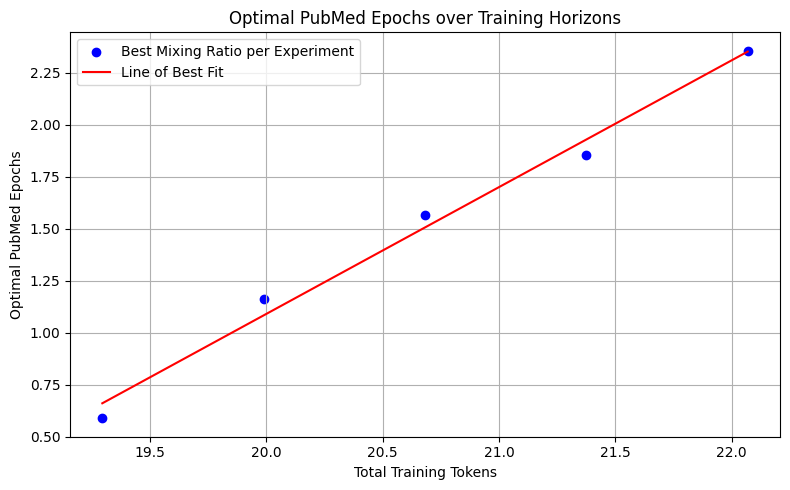

In [19]:
# Logistic Regression, multiply the mixing ratio by the number of wikipedia tokens to get the epochs of Wikipedia 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

df_best = get_best_overall_runs(file_paths_reg, pubmed_tokens)
df_best["experiment"] = df_best["experiment"].astype(float)

df_best["optimal_pubmed_epochs"] = df_best["experiment"] * (1 - df_best["mixing_ratio"])
df_best["tokens"] = (df_best["experiment"] * 120000060)
# df_best["log_wiki_epochs"] = np.log(df_best["wiki_epochs"])

# X = wiki_epochs, y = optimal mixing_ratio
X = (np.log(df_best[["tokens"]].values))
y = (np.log(df_best["optimal_pubmed_epochs"].values))

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X, y)

import matplotlib.pyplot as plt
x_test = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred = reg.predict(x_test)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color="blue", label="Best Mixing Ratio per Experiment")
plt.plot(x_test, y_pred, color="red", label="Line of Best Fit")
plt.xlabel("Total Training Tokens")

plt.ylabel("Optimal PubMed Epochs")
plt.title("Optimal PubMed Epochs over Training Horizons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wikipedia usually considered ~ highest quality 
# do repeat scaling laws for lower quality domains
# fineweb edu

In [21]:
print(32*7542142)
print(32*15030384)

241348544
480972288


In [ ]:
# Old Plotting Code
from scipy.special import logit
iter_values = [7110, 14280, 28566, 57118, 114142]
file_paths = []
model_params = ["124M"]
subsamples = [16, 8, 4, 2, 1]
for model in model_params:
    for i in range(len(iter_values)):
        file_paths.append(f"./summary_logs/wikipedia/summary_{iter_values[i]}iter_{model}_{subsamples[i]}.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
wiki_tokens = [2,4,8,16,32]
legend_labels = ["232M, 1/16 subsample", "468M, 1/8 subsample", "936M, 1/4 subsample", "1.87B, 1/2 subsample", "3.74B (Target)"]
dfs = best_runs(file_paths, wiki_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


# 
# plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)
legend_labels_reg = ["234M, 2x Wikipedia", "468M, 4x Wikipedia", "935M, 8x Wikipedia", "1.87B, 16x Wikipedia", "3.74B, 32x Wikipedia"]
iter_values_reg = [7134, 14268, 28536, 57071, 114142]
file_paths_reg = []
model_params = ["124M"]
legend_idx = 0
for model in model_params:
    for val in iter_values_reg:
        file_paths_reg.append(f"./summary_logs/wikipedia/summary_{val}iter_{model}_1.txt")
        
dfs_reg = best_runs(file_paths_reg, wiki_tokens)  
for df in dfs_reg:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels_reg[legend_idx]}"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', linestyle='--', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("Wikipedia: Validation Loss per Mixing Ratio Across Training Horizons. Repeat-Aware Simulating 32x Epochs in Solid, Regular in Dashed")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.special import logit
iter_values = [7134, 14268, 28536, 57071, 114142]
file_paths = []
model_params = ["124M"]
for model in model_params:
    for val in iter_values:
        file_paths.append(f"./summary_logs/wikipedia/summary_{val}iter_{model}_1.txt")

#file_paths.append(f"./summary_logs_new/summary_58148iter.txt")
# file_paths = ["./summary_logs/summary_58148iter.txt", "./summary_logs/summary_29074iter.txt", "./summary_logs/summary_14537iter.txt", "./summary_logs/summary_7269iter.txt"]
#wiki_tokens = [2, 4, 8, 16, "(New) 16"]
wiki_tokens = [2,4,8,16,32]
legend_labels = ["234M", "468M", "935M", "1.87B", "3.74B"]
dfs = best_runs(file_paths, wiki_tokens)

# Display each DataFrame
for df in dfs:
    print(f"Dataframe for {df['experiment'].iloc[0]}x Wikipedia")
    display(df.drop(columns=["experiment"]))

plt.figure(figsize=(10, 6))
legend_idx = 0
for df in dfs:
    label = df["experiment"].iloc[0]
    # plot_label = f"{label}x Wikipedia"
    plot_label = f"{legend_labels[legend_idx]} tokens, {label}x Wikipedia"
    legend_idx += 1

    # inverse logits space 
    
    #ratios = df["mixing_ratio"].clip(1e-6, 1 - 1e-6)
    #logit_ratios = np.log(ratios / (1 - ratios))
    #logit_ratios = logit(df["mixing_ratio"].clip(1e-6, 1 - 1e-6))
    
    #plt.plot(logit_ratios, df["val_loss"], marker='o', label=plot_label)

    # normal space
    plt.plot(df["mixing_ratio"], df["val_loss"], marker='o', label=plot_label)


plt.xlabel("Mixing Ratio (Proportion of FineWeb)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Mixing Ratio Across Training Horizons")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# bracket between the previous best learning rate and 1/2 the prev best learning rate?